In [1]:
from os.path import isfile, join
from os import listdir
from tqdm.auto import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
from modules.models import ResnetGenerator, Discriminator
from modules.dataset import make_dataloader

from config import TrainerConfig, ModelConfig

In [2]:
train_config = TrainerConfig()
model_config = ModelConfig()
device_num = 4
path_data = 'AAPM_data'
device = torch.device(f"cuda:{device_num}" if torch.cuda.is_available() else "cpu")
_, test_dataloader = make_dataloader(path_data, train_config.batch_size)
path_result = join(train_config.path_checkpoint, model_config.model_name)

In [6]:
# Designate the model path
train_config.path_checkpoint = 'CT_denoising_best'
model_config.model_name = 'cyclegan_best'
path_result = join(train_config.path_checkpoint, model_config.model_name)

In [7]:
c = model_config

G_Q2F = ResnetGenerator(
    *c.G_Q2F.args, **c.G_Q2F.kwargs
).to(device)        

In [8]:
from tqdm.auto import tqdm

# Load the last checkpoint
checkpoint = torch.load(join(train_config.path_checkpoint, model_config.model_name + '.pth'))
G_Q2F.load_state_dict(checkpoint['G_Q2F_state_dict'])
G_Q2F.eval()

# Test and save
with torch.no_grad():
  for _, x_Q, file_name in tqdm(test_dataloader):
    x_Q = x_Q.to(device)
    x_QF = G_Q2F(x_Q)[0].detach().cpu().numpy()
    x_QF = x_QF * 4000

    np.save(join(path_result, file_name[0]), x_QF)

  0%|          | 0/421 [00:00<?, ?it/s]

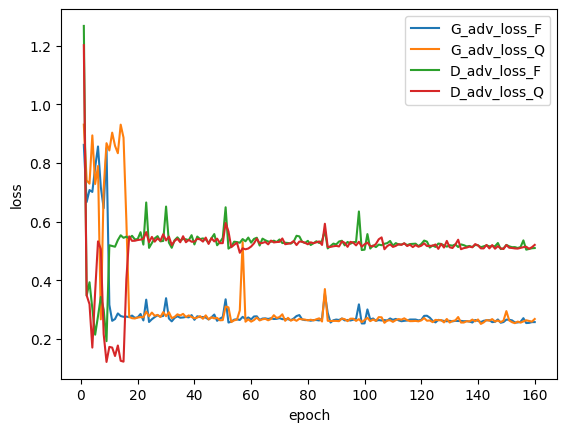

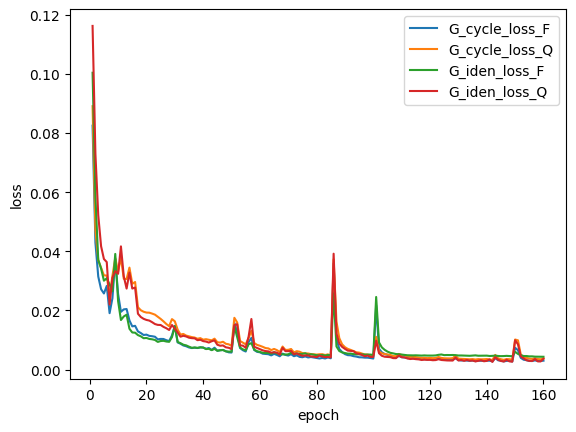

In [9]:
# Plot loss graph (adversarial loss)
x_axis = np.arange(1, train_config.num_epoch + 1)
plt.figure(1)
for name in ['G_adv_loss_F', 'G_adv_loss_Q', 'D_adv_loss_F', 'D_adv_loss_Q']:
  loss_arr = torch.load(join(path_result, name + '.npy'))
  loss_arr = [tensor.cpu().numpy() for tensor in loss_arr] 
  plt.plot(x_axis, loss_arr, label=name)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig(join(path_result, 'loss_curve_1.png'))
plt.show()

# Plot loss graph (cycle consistency loss, identity loss)
plt.figure(2)
for name in ['G_cycle_loss_F', 'G_cycle_loss_Q', 'G_iden_loss_F', 'G_iden_loss_Q']:
  loss_arr = torch.load(join(path_result, name + '.npy'))
  loss_arr = [tensor.cpu().numpy() for tensor in loss_arr] 
  plt.plot(x_axis, loss_arr, label=name)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig(join(path_result, 'loss_curve_2.png'))
plt.show()

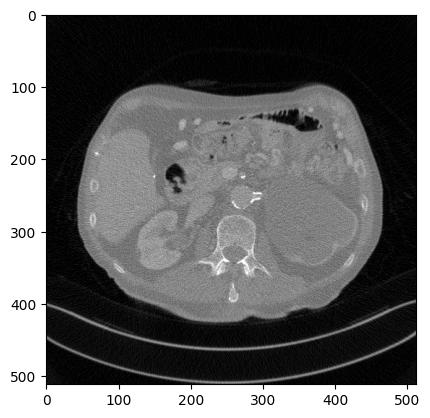

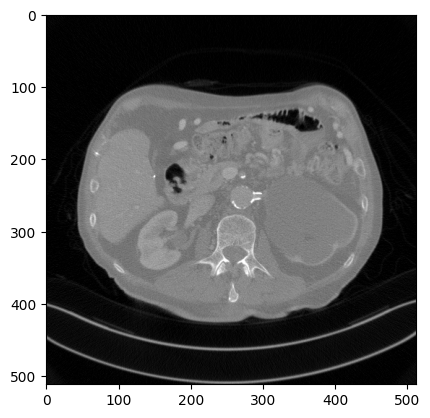

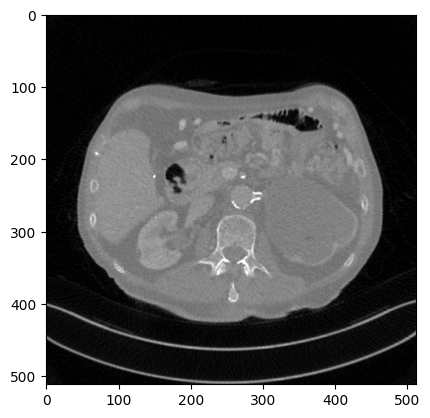

In [10]:
# Example of result
path_quarter = join(path_data, 'test/quarter_dose/100.npy')
path_full = join(path_data, 'test/full_dose/100.npy')
path_output = join(path_result, '100.npy')

quarter = np.load(path_quarter)
full = np.load(path_full)
output = np.load(path_output)

quarter = (quarter - 0.0192) / 0.0192 * 1000
full = (full - 0.0192) / 0.0192 * 1000

quarter = np.clip(quarter, -1000, 1000)
full = np.clip(full, -1000, 1000)
output = np.clip(output, -1000, 1000)

output = np.transpose(output, (1, 2, 0))

plt.imshow(quarter, cmap='gray')
plt.show()
plt.imshow(full, cmap='gray')
plt.show()
plt.imshow(output, cmap='gray')
plt.show()

In [11]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Functions for caculating PSNR, SSIM
def psnr(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = peak_signal_noise_ratio(ref, A)
  return out

def ssim(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = structural_similarity(ref, A, data_range=2)
  return out

In [12]:
# Average value of all test data (PSNR, SSIM)
psnr_list_input = list()
psnr_list_network = list()
psnr_list_network_sup = list()
ssim_list_input = list()
ssim_list_network = list()
ssim_list_network_sup = list()

for file_name in tqdm(listdir(join(path_data, 'test/full_dose'))):
    path_quarter = join(path_data, 'test/quarter_dose', file_name)
    path_full = join(path_data, 'test/full_dose', file_name)
    path_output = join(path_result, file_name)
    path_output_sup = join(path_result, 'sup' + file_name)
    
    quarter = np.load(path_quarter)
    full = np.load(path_full)
    output = np.load(path_output)
    
    output = np.transpose(output, (1, 2, 0)).squeeze(2)
    
    quarter = (quarter - 0.0192) / 0.0192 * 1000
    full = (full - 0.0192) / 0.0192 * 1000
    
    psnr_list_input.append(psnr(quarter, full))
    psnr_list_network.append(psnr(output, full))
    ssim_list_input.append(ssim(quarter, full))
    ssim_list_network.append(ssim(output, full))
    
print('Mean PSNR between input and ground truth:', np.mean(psnr_list_input))
print('Mean SSIM between input and ground truth:', np.mean(ssim_list_input))
print('Mean PSNR between network output and ground truth:', np.mean(psnr_list_network))
print('Mean SSIM between network output and ground truth:', np.mean(ssim_list_network))

  0%|          | 0/421 [00:00<?, ?it/s]

Mean PSNR between input and ground truth: 34.16952392478545
Mean SSIM between input and ground truth: 0.8931997874844594
Mean PSNR between network output and ground truth: 37.49751060768049
Mean SSIM between network output and ground truth: 0.9543364706254154
